### imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import os
import time
import datetime

Try : HistGBM , Bagging, Neural Network BC 

In [2]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col = 'id')

### Initial EDA

In [3]:
train.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
5,24,admin.,single,secondary,no,1882,yes,no,cellular,20,apr,1010,3,-1,0,unknown,0
6,39,blue-collar,married,secondary,no,0,no,no,telephone,21,nov,90,1,-1,0,unknown,0
7,50,admin.,single,secondary,no,1595,no,no,telephone,31,jul,49,25,-1,0,unknown,0
8,46,blue-collar,married,primary,no,1463,no,no,cellular,4,aug,50,1,-1,0,unknown,0


In [4]:
train.shape

(750000, 17)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 103.0+ MB


In [6]:
numerical_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include=object).columns

print(f'Numerical Cols : {numerical_cols.values} \n Categorical Cols: {categorical_cols.values}')

Numerical Cols : ['age' 'balance' 'day' 'duration' 'campaign' 'pdays' 'previous' 'y'] 
 Categorical Cols: ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'poutcome']


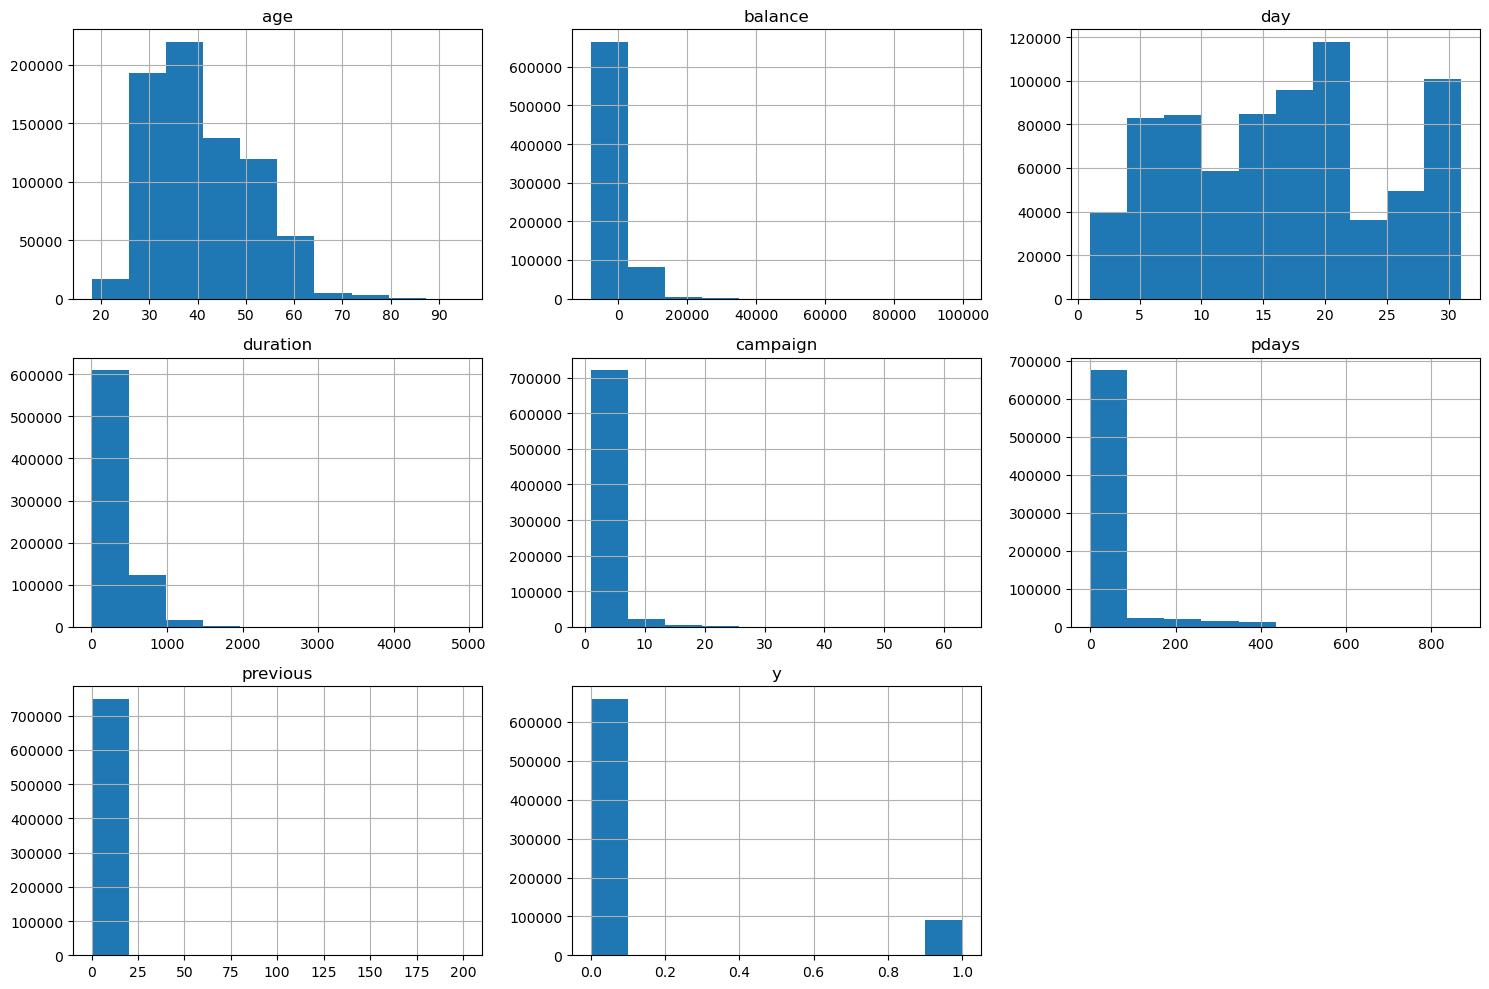

In [7]:
train[numerical_cols].hist(figsize=(15,10))
plt.tight_layout()
plt.title('Numerical Histograms')
plt.show()

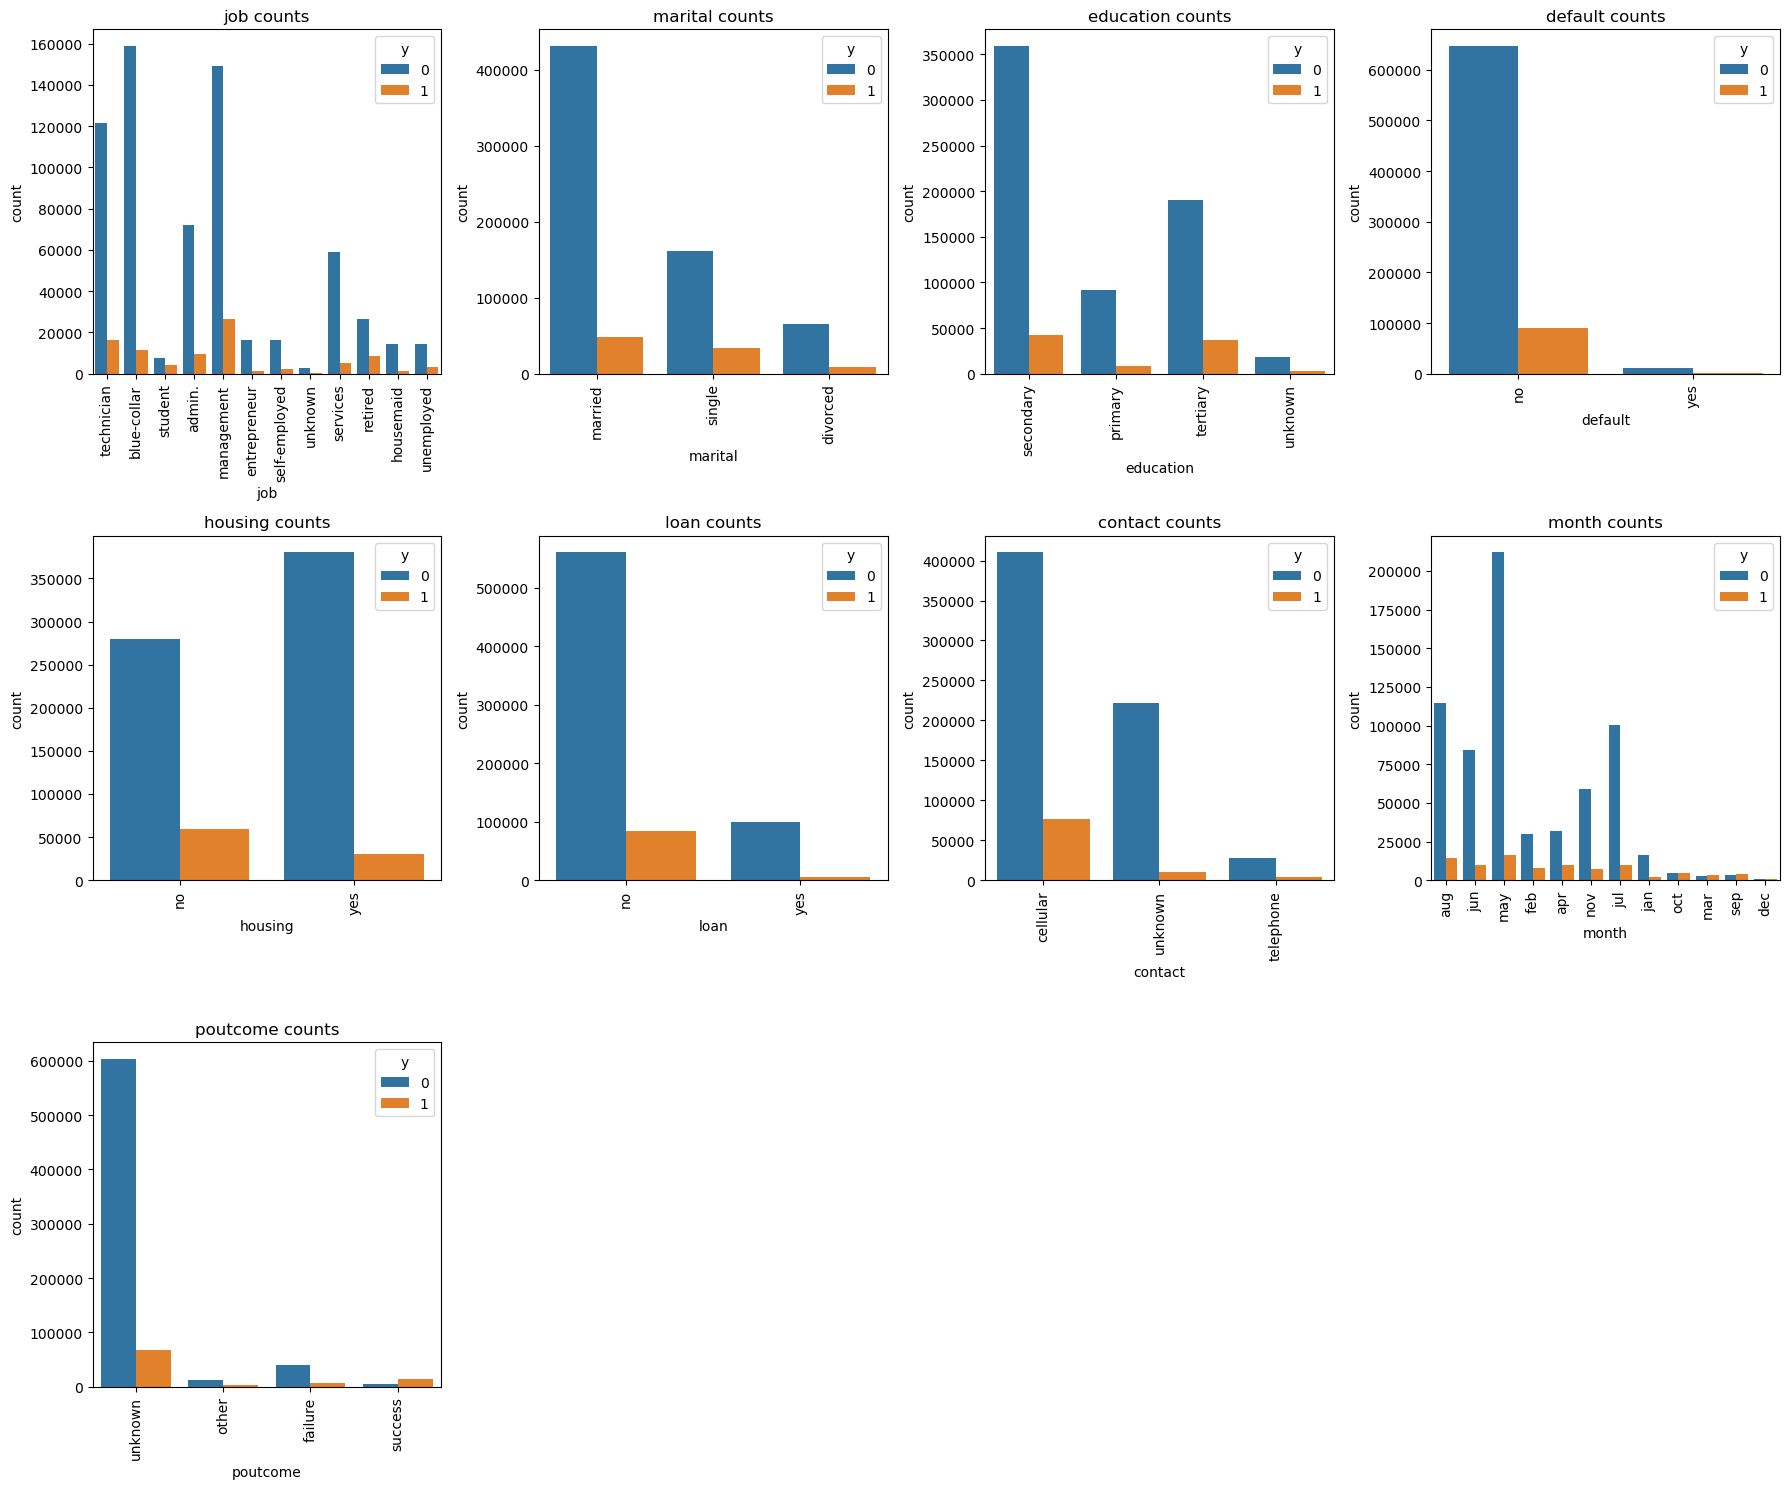

In [8]:
fig, axes = plt.subplots(ncols=4, nrows=(3), figsize = (18,15))
axes = axes.flatten()

for ax,col in zip(axes , categorical_cols):    
        ax.set_title(f'{col} counts')
        sns.countplot(data=train, x=col, hue='y', ax=ax)
        ax.tick_params(axis='x', labelrotation = 90)
        
for ax in axes[len(categorical_cols):]:
        ax.set_visible(False)
        
plt.tight_layout()
plt.show()

In [9]:
for col in train.columns:
    print(train[col].value_counts())

age
32    37235
33    34511
31    34301
34    34131
35    33057
      ...  
90        6
92        5
94        4
95        3
91        1
Name: count, Length: 78, dtype: int64
job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64
marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64
education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64
default
no     737151
yes     12849
Name: count, dtype: int64
balance
 0        93159
 5         4174
 4         3741
-1         3573
 3         3429
          ...  
 8943         1
 52496        1
 10821        1
 52357        1
 8218         1
Name: count, Length: 8217, dtype: int64
housing
yes    

<Axes: >

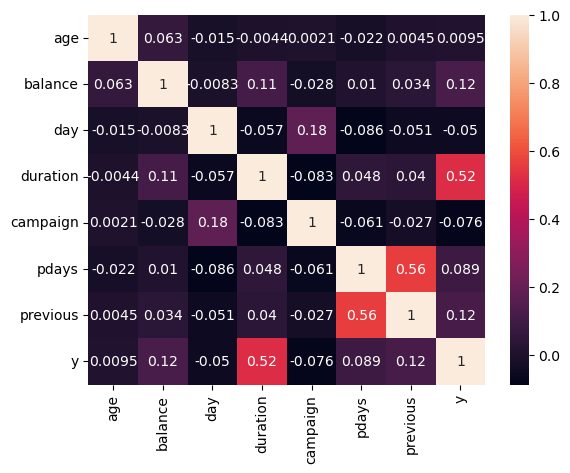

In [10]:
sns.heatmap(train[numerical_cols].corr(), annot=True)

### Data Processing

In [11]:
train_encoded = pd.get_dummies(data=train, columns=categorical_cols, drop_first=False)

In [12]:
numerical_cols = numerical_cols.drop('y')

In [13]:
scaler = StandardScaler()
train_encoded[numerical_cols] = scaler.fit_transform(train_encoded[numerical_cols])
train_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
id,,,,,,,,,,,,,,,,,,,,,
0,0.106310,-0.422083,1.076594,-0.510829,0.155597,-0.302803,-0.223475,0,False,False,...,False,False,False,False,False,False,False,False,False,True
1,-0.289776,-0.243316,0.228194,-0.261338,-0.580100,-0.302803,-0.223475,0,False,True,...,True,False,False,False,False,False,False,False,False,True
2,-0.487819,-0.212287,-0.256606,-0.532843,-0.212251,-0.302803,-0.223475,0,False,True,...,False,False,True,False,False,False,False,False,False,True
3,-1.379012,-0.412563,1.440194,-0.903409,-0.212251,-0.302803,-0.223475,0,False,False,...,False,False,True,False,False,False,False,False,False,True
4,-1.478033,-0.111092,-1.589805,2.369319,-0.580100,-0.302803,-0.223475,1,False,False,...,False,False,False,False,False,False,False,False,False,True


In [14]:
test_encoded = pd.get_dummies(data=test, columns=categorical_cols, drop_first=False)
test_encoded[numerical_cols] = scaler.fit_transform(test_encoded[numerical_cols])

### t-SNE

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


pca = PCA(n_components=2, random_state=42)

pipe = Pipeline([

    ("pca", pca)
])

X_reduced = pipe.fit_transform(train_encoded.drop(columns=['y']))   # df is your dataset
print(X_reduced.shape)  # (n_samples, 2)


(750000, 2)


In [43]:
X_red = pd.DataFrame(X_reduced, columns=['x','y1'])

In [47]:
X_red

,x,y1
0,-0.740143,0.807801
1,-0.546401,-0.165960
2,-0.404390,0.149626
3,-0.682891,1.587712
4,0.460957,-1.589701
...,...,...
749995,0.174182,-1.628254
749996,-0.559354,-0.871599
749997,-0.324515,-0.228858
749998,-0.908411,1.800535


In [48]:
train_encoded = pd.concat([X_red,train_encoded['y'].reset_index(drop=True)], axis = 1)

<Axes: xlabel='x', ylabel='y1'>

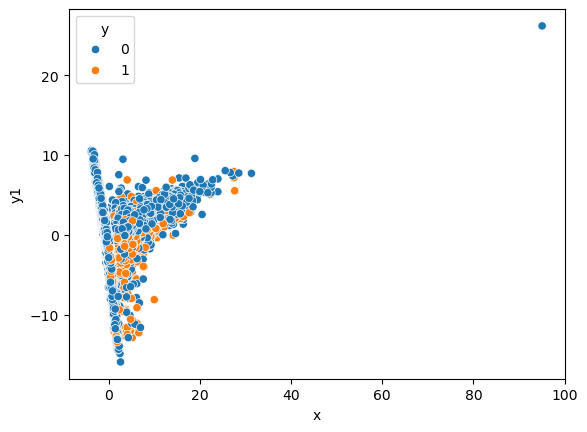

In [50]:
sns.scatterplot(data=train_encoded, x='x',y='y1',hue='y')

### HGB

In [15]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

X = train.drop(columns=['y'])
y = train['y']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [16]:
HGB = HistGradientBoostingClassifier(categorical_features=categorical_cols).fit(X_train,y_train)

pred_HGB = HGB.predict(X_test)
pred_prob_HGB = HGB.predict_proba(X_test)

In [17]:
print(classification_report(y_test, pred_HGB))
print(f'Accuracy: {accuracy_score(y_test, pred_HGB)}')
print(f'F1 Score: {f1_score(y_test, pred_HGB)}')

              precision    recall  f1-score   support

           0       0.95      0.97      0.96    131942
           1       0.76      0.66      0.71     18058

    accuracy                           0.93    150000
   macro avg       0.86      0.82      0.83    150000
weighted avg       0.93      0.93      0.93    150000

Accuracy: 0.9336933333333334
F1 Score: 0.7070225050076587


### LR

In [18]:
X_enc = train_encoded.drop(columns=['y'])
y_enc = train_encoded['y']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_enc,y_enc,test_size=0.2)

In [19]:
LR = LogisticRegression(penalty='l2',max_iter=100,tol=1e-4,solver='lbfgs', random_state= 42).fit(X_train2,y_train2)

pred_LR = LR.predict(X_test2)
pred_prob_LR = LR.predict_proba(X_test2)

In [20]:
print(classification_report(y_test, pred_LR))
print(f'Accuracy: {accuracy_score(y_test, pred_LR)}')
print(f'F1 Score: {f1_score(y_test, pred_LR)}')

              precision    recall  f1-score   support

           0       0.88      0.91      0.90    131942
           1       0.12      0.08      0.10     18058

    accuracy                           0.81    150000
   macro avg       0.50      0.50      0.50    150000
weighted avg       0.79      0.81      0.80    150000

Accuracy: 0.8138466666666667
F1 Score: 0.09602123733367865


In [21]:
LR2 = LogisticRegression(penalty='l1',solver='saga',max_iter=2000, tol=1e-3, random_state= 42).fit(X_train2,y_train2)

pred_LR2 = LR2.predict(X_test2)
pred_prob_LR2 = LR2.predict_proba(X_test2)

In [22]:
print(classification_report(y_test, pred_LR2))
print(f'Accuracy: {accuracy_score(y_test, pred_LR2)}')
print(f'F1 Score: {f1_score(y_test, pred_LR2)}')

              precision    recall  f1-score   support

           0       0.88      0.91      0.90    131942
           1       0.12      0.08      0.10     18058

    accuracy                           0.81    150000
   macro avg       0.50      0.50      0.50    150000
weighted avg       0.79      0.81      0.80    150000

Accuracy: 0.8136533333333333
F1 Score: 0.09598965071151358


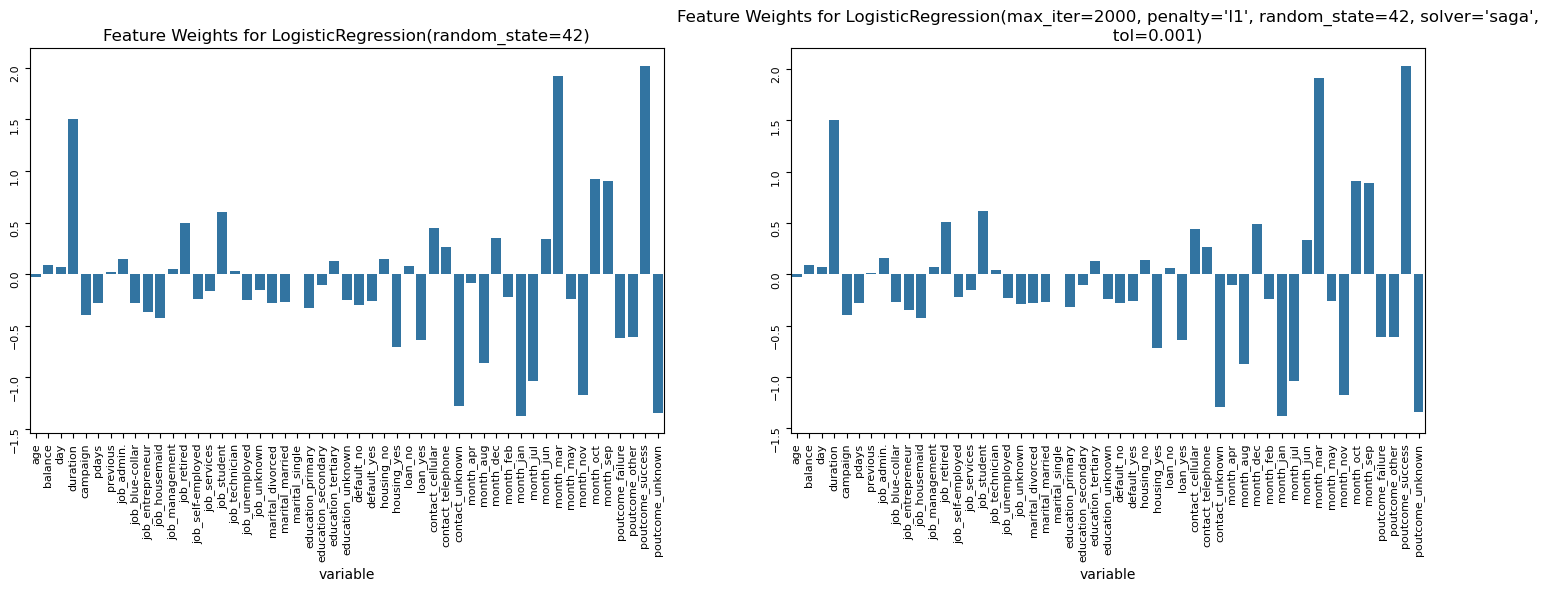

In [23]:
encoded_cols = test_encoded.columns
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (18,5))

for ax, model in zip(axes, (LR,LR2)):
    coefs = model.coef_[0]

    sns.barplot(x=encoded_cols, y=coefs, ax= ax)
    ax.set_title(f'Feature Weights for {model}')
    ax.tick_params(rotation = 90, labelsize = 8)
    ax.set_xlabel('variable')

In [24]:
LR_coefs = LR.coef_[0]
d = {'col1' : test_encoded.columns , 'col2' : LR_coefs}
df = pd.DataFrame(data=d)

In [25]:
names = ['job', 'marital', 'education', 'default', 'housing','loan','contact','month','poutcome']
def join_rows(names, df):
    for col in names:
        selected_rows = df[df['col1'].str.startswith(f'{col}_')]
        others = df[~df['col1'].str.startswith(f'{col}_')]

        total = selected_rows['col2'].sum()
        new_row = pd.DataFrame({'col1' : f'{col}', 'col2' : [total]})

        df = pd.concat([others, new_row])

    return df

df = join_rows(names, df)

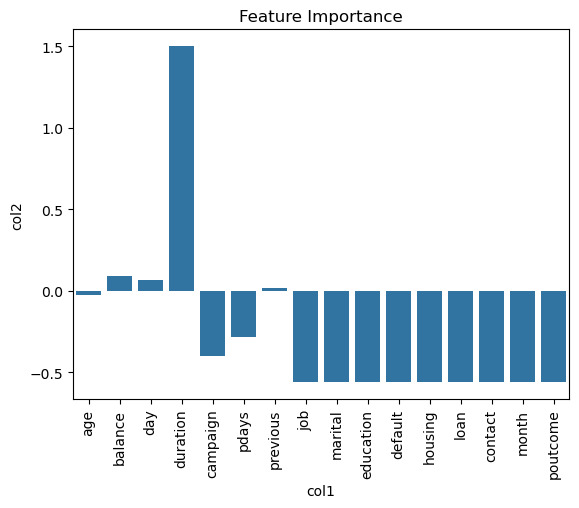

In [26]:
sns.barplot(data=df, x='col1', y ='col2')
plt.title('Feature Importance')
plt.xticks(rotation = 90)
plt.show()

### output

In [28]:
final_pred = LR.predict_proba(test_encoded)[:,1]
df = pd.DataFrame(data=final_pred,index=range(750000,1000000))

now = datetime.datetime.now()
folder_path = now.strftime("%d-%m-%Y")
file_path = "LR " + now.strftime('%H%M.csv')

os.makedirs(folder_path, exist_ok=True)

path = os.path.join(folder_path, file_path)

df.to_csv(path, header=['y'], index=True, index_label='id')
